In [1]:
!pip install -U sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the CSV file
df = pd.read_csv("/content/CDMX_Sentiment_Comparation.csv", encoding="latin1")

# Ensure consistent types
df["Number"] = df["Number"].astype(str)
df["respuesta"] = df["respuesta"].astype(str)

# Load the multilingual embedding model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Filter real and generated responses
df_real = df[df["tipo"] == "real"]
df_gen = df[df["tipo"] == "generada"]

# Group responses by question number (concatenate all responses per question)
grouped_real = df_real.groupby("Number")["respuesta"].apply(lambda x: " ".join(x)).reset_index()
grouped_gen = df_gen.groupby("Number")["respuesta"].apply(lambda x: " ".join(x)).reset_index()

# Merge both groups on the question number
df_merged = pd.merge(grouped_real, grouped_gen, on="Number", suffixes=("_real", "_gen"))

# Generate embeddings
emb_real = model.encode(df_merged["respuesta_real"].tolist(), convert_to_tensor=True)
emb_gen = model.encode(df_merged["respuesta_gen"].tolist(), convert_to_tensor=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Filter to keep only question numbers present in both sets
valid_numbers = set(df_real["Number"]).intersection(set(df_gen["Number"]))
df_valid = df_merged[df_merged["Number"].isin(valid_numbers)].copy()

# Initialize list for similarity scores
similarities = []

# Compute cosine similarity for each valid question
for i, row in df_valid.iterrows():
    try:
        # Generate embeddings
        emb_r = model.encode(row["respuesta_real"], convert_to_tensor=True).unsqueeze(0)
        emb_g = model.encode(row["respuesta_gen"], convert_to_tensor=True).unsqueeze(0)

        # Compute cosine similarity
        sim = cosine_similarity(emb_r.cpu().numpy(), emb_g.cpu().numpy())[0][0]
    except Exception as e:
        sim = None

    similarities.append(sim)

# Add results to the dataframe
df_valid["semantic_similarity"] = similarities

# Display final table
df_valid[["Number", "semantic_similarity"]]


,Number,semantic_similarity
0,1.0,0.476901
1,2.0,0.558504


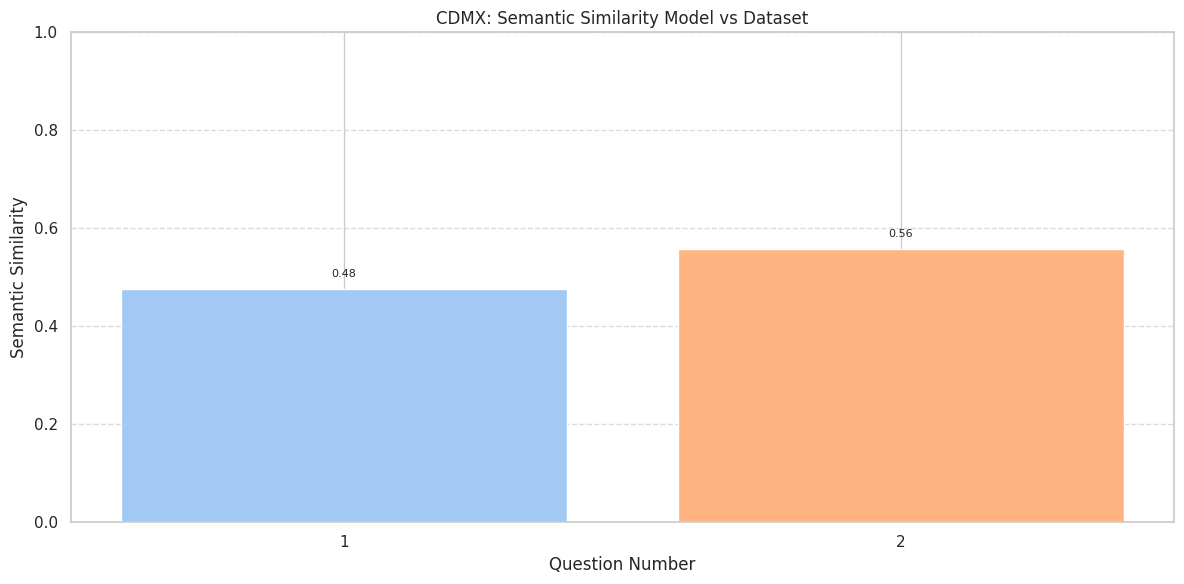

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for consistency
sns.set(style="whitegrid")

# Ensure 'Number' column is of integer type for plotting
df_valid["Number"] = df_valid["Number"].astype(float).astype(int)
df_merged["Number"] = df_merged["Number"].astype(float).astype(int)


# Plot semantic similarity by question
plt.figure(figsize=(12, 6))
# Use different colors, perhaps from the 'pastel' palette
colors = sns.color_palette('pastel', len(df_valid))
plt.bar(df_valid["Number"], df_valid["semantic_similarity"], color=colors)

# Add labels and title
plt.title('CDMX: Semantic Similarity Model vs Dataset')
plt.xlabel("Question Number")
plt.ylabel("Semantic Similarity")
plt.ylim(0, 1)  # similarity scores range from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set x-axis ticks to be the question numbers
plt.xticks(df_valid["Number"])

# Add value labels on top of bars (optional)
for i, v in enumerate(df_valid["semantic_similarity"]):
    plt.text(df_valid["Number"].iloc[i], v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=8)


plt.tight_layout()
plt.show()

# Convert embedding tensors to lists
# df_merged["embedding_real"] = [vec.tolist() for vec in emb_real] # These embeddings are already added in cell LxtQBAjVWP_r
# df_merged["embedding_gen"] = [vec.tolist() for vec in emb_gen] # These embeddings are already added in cell LxtQBAjVWP_r

# Merge similarity scores from df_valid
df_export = pd.merge(df_merged, df_valid[["Number", "semantic_similarity"]], on="Number", how="left")

# Export to CSV
df_export.to_csv("/content/MTY_Semantic_Embeddings.csv", index=False)


In [5]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the model (si no lo has cargado antes)
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Asegúrate de tener bien cargado el CSV con los valores correctos
df = pd.read_csv("/content/CDMX_Sentiment_Comparation.csv", encoding="latin1")

# Clean and prepare
df["respuesta"] = df["respuesta"].astype(str)
df["Number"] = df["Number"].astype(str)

# Generate embeddings for each response individually
embeddings = model.encode(df["respuesta"].tolist(), convert_to_tensor=False)

# Add them as a new column
df["embedding"] = [e.tolist() for e in embeddings]

# Save the full DataFrame with embeddings
df.to_csv("/content/CDMX_AllResponses_withEmbeddings.csv", index=False)


In [6]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load data
df = pd.read_csv('/content/CDMX_Sentiment_Comparation.csv', encoding='latin1')
df = df.dropna(subset=['respuesta', 'Number', 'tipo'])
df["respuesta"] = df["respuesta"].astype(str)
df["Number"] = df["Number"].astype(str)

# Load sentence embedding model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

results = []

# Loop over each question
for q in sorted(df['Number'].unique()):
    df_q = df[df['Number'] == q]

    # Get all real responses
    real_responses = df_q[df_q['tipo'] == 'real']['respuesta'].dropna().tolist()

    if len(real_responses) < 2:
        continue  # not enough data to compute reference

    # Create reference embedding for the full set of real responses
    real_reference_text = " ".join(real_responses)
    ref_embedding = model.encode(real_reference_text, convert_to_tensor=True).unsqueeze(0)

    # Compare each generated response to real reference
    for r in df_q[df_q['tipo'] == 'generada']['respuesta'].dropna().tolist():
        emb_r = model.encode(r, convert_to_tensor=True).unsqueeze(0)
        score = cosine_similarity(ref_embedding.cpu().numpy(), emb_r.cpu().numpy())[0][0]
        results.append({'tipo': 'generada', 'pregunta': int(float(q)), 'cosine_semantico': score})

    # Leave-one-out for real responses
    real_list = df_q[df_q['tipo'] == 'real']['respuesta'].dropna().tolist()
    for i, r in enumerate(real_list):
        other_real = real_list[:i] + real_list[i+1:]
        if not other_real:
            continue
        ref_text = " ".join(other_real)
        ref_emb = model.encode(ref_text, convert_to_tensor=True).unsqueeze(0)
        emb_r = model.encode(r, convert_to_tensor=True).unsqueeze(0)
        score = cosine_similarity(ref_emb.cpu().numpy(), emb_r.cpu().numpy())[0][0]
        results.append({'tipo': 'real', 'pregunta': int(float(q)), 'cosine_semantico': score})

# Save and display
df_sem_sim = pd.DataFrame(results)
df_sem_sim.to_csv('/content/semantic_similarity_vs_question_set.csv', index=False)
df_sem_sim.head()


,tipo,pregunta,cosine_semantico
0,generada,1,0.452662
1,generada,1,0.444602
2,generada,1,0.281238
3,generada,1,0.489437
4,generada,1,0.257603


/tmp/ipython-input-10-271754153.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_q, x='tipo', y='cosine_semantico', palette='pastel', ax=ax, order=['Model', 'Dataset'], linewidth=2.5)
/tmp/ipython-input-10-271754153.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_q, x='tipo', y='cosine_semantico', palette='pastel', ax=ax, order=['Model', 'Dataset'], linewidth=2.5)


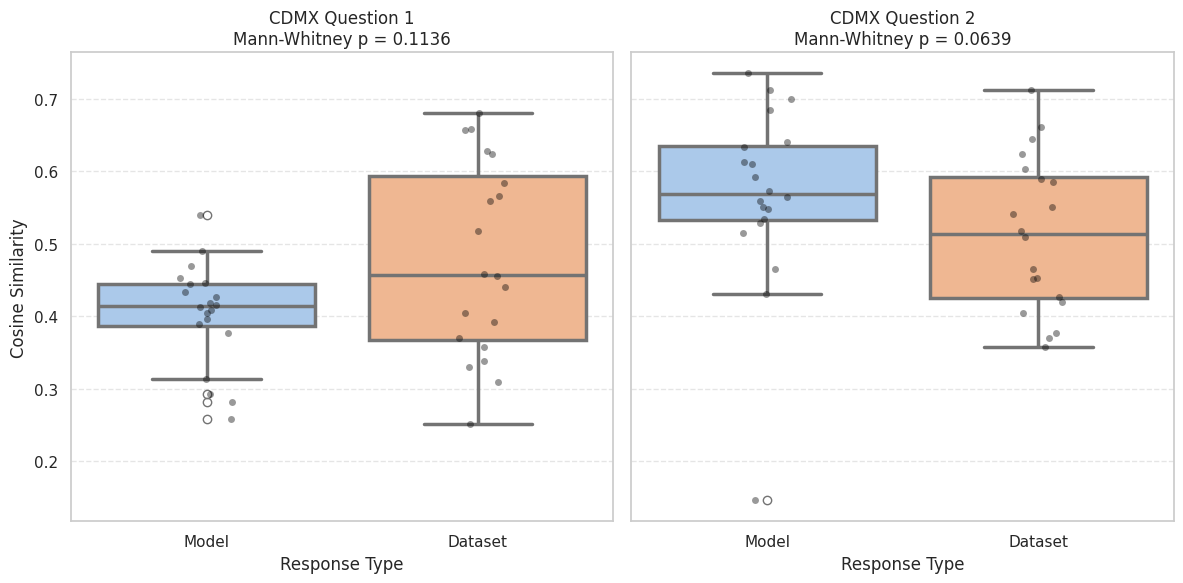


Resultados estadísticos por pregunta:
Pregunta 1: U = 259.0, p = 0.1136 → 🔍 No significativa
Pregunta 2: U = 131.0, p = 0.0639 → 🔍 No significativa


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# Get unique question numbers
questions = df_sem_sim['pregunta'].unique()

# Set up figure for subplots
n_questions = len(questions)
n_cols = 2 if n_questions > 1 else 1
n_rows = int(np.ceil(n_questions / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), sharey=True)

# Flatten the array of axes for easy iteration
axes = axes.flatten() if n_questions > 1 else [axes]

# Store results
stat_results = []

# Loop over each question
for i, q in enumerate(sorted(questions)):
    ax = axes[i]

    # Filter data for this question
    df_q = df_sem_sim[df_sem_sim['pregunta'] == q].copy()
    real_scores = df_q[df_q['tipo'] == 'real']['cosine_semantico']
    gen_scores = df_q[df_q['tipo'] == 'generada']['cosine_semantico']

    # Mann-Whitney U test
    if len(real_scores) > 0 and len(gen_scores) > 0:
        u_stat, p_value = mannwhitneyu(real_scores, gen_scores, alternative='two-sided')
        stat_results.append({'pregunta': q, 'U': u_stat, 'p_value': p_value})
        p_value_text = f'p = {p_value:.4f}'
        if p_value < 0.05:
            p_value_text += ' ✅'
    else:
        p_value_text = 'No enough data for test'


    # Boxplot + stripplot
    # Rename labels for clarity
    df_q['tipo'] = df_q['tipo'].replace({'real': 'Dataset', 'generada': 'Model'})
    sns.boxplot(data=df_q, x='tipo', y='cosine_semantico', palette='pastel', ax=ax, order=['Model', 'Dataset'], linewidth=2.5)
    sns.stripplot(data=df_q, x='tipo', y='cosine_semantico', color='black', alpha=0.4, ax=ax, order=['Model', 'Dataset'])

    ax.set_title(f'CDMX Question {q}\nMann-Whitney {p_value_text}')
    ax.set_xlabel("Response Type")
    ax.set_ylabel('Cosine Similarity' if i % n_cols == 0 else '') # Add ylabel only for the first column
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print test results
print("\nResultados estadísticos por pregunta:")
for r in stat_results:
    signif = "✅ SIGNIFICATIVA" if r['p_value'] < 0.05 else "🔍 No significativa"
    print(f"Pregunta {r['pregunta']}: U = {r['U']}, p = {r['p_value']:.4f} → {signif}")